In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#File Index calculation. Basically given the index, Custom dataset should able to fetch the file from corresponding folders

In [1]:
import numpy as np
import cv2
import io
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
import zipfile
import torchvision.datasets.folder
from PIL import Image
import sys
#sys.path.append('/content/gdrive/My Drive/eva-04/S15A')

import cv2
import numpy as np
import glob
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt

import argparse
import time
import csv

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
#import  models

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# This is the common class for both test and train data sets. Based on indexes, this class serves the sample.
# we deal with a folder at a time.
#fg_bg and bg are the input. classes are masks 
#example
#root = Dataset150
#bg_file = bg1.jpg
#bg_folder = Dataset150/bg150_1
#fgbg_folder = Dataset150/fgbg150_1
#mask_fgbgbg_folder = Dataset150/mask_fgbg150_1


class BackgroundSubtraction_Dataset_Test(Dataset):

  def __init__(self, root, size, test = False, files=[], transform=ToTensor()):
    'Initialization'
    self.m_root = root
    self.m_bg_folder = os.path.join(self.m_root, "bg150")
    self.m_transform = transform
    self.m_file_dict = dict()
    self.m_index_path_dict = dict()
    self.m_size = size
    self.m_files = files
    self.m_btest = test 
    #self.prepare_indexes224()
  
  
  #bg1
  #   /fg_1
  #      /depth
  #           1.jpg
  #           40.jpg  
  #      /mask_
  #      /overlay
  #   /fg_2
  #     /depth
  #     /mask_
  #     /overlay
  def prepare_indexes224(self):
    bg_folder = "bg"
    fg_folder = "fg_"
    mask_folder = "mask"
    depth_folder = "depth"
    overlay_folder = "overlay"
    bg_index = 1
    fg_index = 1
    file_index = 1 # 1 to 40
    #index_file_dict = dict()

    for i in range(1,4002):
      
      #overlay_file = bg_folder + str(bg_index) + "/" + fg_folder + str(fg_index) + "/"+  "overlay" + "/" + file_index + ".jpg"
      
      path_dir = bg_folder + str(bg_index) + "/" + fg_folder + str(fg_index)
      self.m_index_path_dict[i] = path_dir
      print(i,self.m_index_path_dict[i],file_index)
      
      if file_index == 40:
        file_index = 1 # reset
        fg_index = fg_index + 1 # fg_index increases . next folder
      else:
        file_index = file_index + 1
      
      #file_index = file_index % 40      
      if i % 4000 == 0: # every 4k bg change
        bg_index = bg_index + 1
        file_index = 1 # reset
        fg_index =  1 # fg_index starts from 1. reset
      
      #fgbg_file = bg + str(bg_index) + "_" + str(row) + "_" + str(column)+ "_" + fg + "_"+ str(fg_index)+".jpg"  
  
     
  def __len__(self):
    'Denotes the total number of samples'
    #return len(self.m_files)
    #return len(self.m_size)
    return self.m_size

  def __getitem__(self, idx):

    #index = idx + 4001
    index = idx + 1
    #print("idx=",idx,"index=",index)
    'Generates one sample of data'
    # Select sample
    #file_name = self.m_index_dict.get(index)
    bg_folder ="bg"
    fgbg_folder = "bg"
    fg_folder ="fg_"

    overlay_folder = "overlay"
    mask_folder = "mask"
    depth_folder = "depth"

    bg_index = index // 4000 # each fg can hold till 4000
    if index % 4000 != 0:
      bg_index = bg_index + 1

    # each fg can hold till 40
    fg_index = index // 40
    if index % 40 != 0:
      fg_index = fg_index + 1
  
    fg_index = fg_index % 100 # max cap for fg_index
    if fg_index == 0:
      fg_index =  100 

    file_index = index % 40
    if file_index == 0:
        file_index = 40
    
    fgbg_folder = fgbg_folder + str(bg_index)
    fg_folder = fg_folder + str(fg_index)
    filename = str(file_index)+".jpg"
    #print("filename=",filename)

    #find the bg file:
    bg_path = os.path.join(self.m_root,bg_folder)
    bg_file_name = bg_folder + str(bg_index) + ".jpg"
    bg_file = os.path.join(bg_path,bg_file_name) # bg file
    
    # get fgbg image paths for overlay,depth,mask
    fgbg_path = os.path.join(self.m_root, fgbg_folder)
    fg_folder = os.path.join(fgbg_path,fg_folder)
    overlay_folder = os.path.join(fg_folder,overlay_folder)
    depth_folder = os.path.join(fg_folder,depth_folder) 
    mask_folder = os.path.join(fg_folder,mask_folder)
    overlay_file = os.path.join(overlay_folder,filename) # overlay file
    depth_file = os.path.join(depth_folder,filename) # depth file
    mask_file = os.path.join(mask_folder,filename) # mask file

    # Take all images
    bg_image = Image.open(bg_file).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
    bg_image = bg_image.resize((32,32)) 
    overlay_image = Image.open(overlay_file).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
    overlay_image = overlay_image.resize((32,32)) 
    #depth_image = Image.open(depth_file).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
    #mask_image = Image.open(mask_file).convert('RGB')
    depth_image = Image.open(depth_file) # even grey scale images will be converted to RGB with 3 channels
    depth_image = depth_image.resize((64,64)) 
    mask_image = Image.open(mask_file)
    mask_image = mask_image.resize((64,64)) 
    # Take all images

    try:
      if self.m_transform:
        bg_image = self.m_transform(bg_image)
        overlay_image = self.m_transform(overlay_image)
        tr = transforms.ToTensor()
        mask_image = tr(mask_image)
        depth_image = tr(depth_image)
    except:
      print('Error while transform:', overlay_file, bg_image.shape,overlay_image.shape,mask_image.shape)
    input_array = []
    input_array.append(bg_image)
    input_array.append(overlay_image)
    input_array.append(depth_image)
    input_array.append(mask_image)
    input_array.append(filename)

    return input_array

    #return [bg_image,overlay_image, depth_image,mask_image]



cuda


In [0]:
!mkdir Dataset_224

In [4]:
cd Dataset_224/

/content/Dataset_224


In [5]:
!unzip "/content/gdrive/My Drive/eva-04/S15A/Dataset_224.zip"

Streaming output truncated to the last 5000 lines.
  inflating: bg44/fg_76/mask/31.jpg  
  inflating: bg44/fg_76/mask/8.jpg   
  inflating: bg44/fg_76/mask/9.jpg   
  inflating: bg44/fg_76/mask/6.jpg   
  inflating: bg44/fg_76/mask/37.jpg  
  inflating: bg44/fg_76/mask/32.jpg  
  inflating: bg44/fg_76/mask/29.jpg  
  inflating: bg44/fg_76/mask/39.jpg  
  inflating: bg44/fg_76/mask/38.jpg  
  inflating: bg44/fg_76/mask/24.jpg  
  inflating: bg44/fg_76/mask/11.jpg  
  inflating: bg44/fg_76/mask/23.jpg  
  inflating: bg44/fg_76/mask/5.jpg   
  inflating: bg44/fg_76/mask/33.jpg  
  inflating: bg44/fg_76/mask/10.jpg  
  inflating: bg44/fg_76/mask/1.jpg   
  inflating: bg44/fg_76/mask/3.jpg   
  inflating: bg44/fg_76/mask/16.jpg  
  inflating: bg44/fg_76/mask/20.jpg  
  inflating: bg44/fg_76/mask/17.jpg  
  inflating: bg44/fg_76/mask/40.jpg  
  inflating: bg44/fg_76/mask/15.jpg  
  inflating: bg44/fg_76/mask/14.jpg  
  inflating: bg44/fg_76/mask/27.jpg  
  inflating: bg44/fg_76/mask/36.jpg  

In [6]:
cd ../

/content


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class DenseDepthDNN2(torch.nn.Module):
    def __init__(self, dropout_value = 0.1):
        """"Constructor of the class"""
        super(DenseDepthDNN2, self).__init__()
        # Input Block
        self.dropout_value = dropout_value
        #Depthwise separate 3 input channels into 3 output channels
        #it's first block uses following code:
        #x1 = Input
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        #x12 = GAP(x11)
        #x13 = FC(x12)
        #Uses ReLU and BN wherever applicable
        #Uses CIFAR10 as the dataset
        #Your target is 75% in less than 40 Epochs
        #self.conv1 = nn.Conv2d(3, 6, 5)  # RF= 
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        #torch.nn.Conv2d(in_channels, out_channels=k*in_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        #self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #x1 = Input 
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        
        #x1 = Input 3 channels
        #x2 = Conv(x1)

        self.x2 = nn.Sequential( #input 64*64*64, output=64*64*64, RF=2
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        #x3 = Conv(x1 + x2) , no x1
        self.x3 = nn.Sequential(  #input 64*64*64, output=64*64*64, RF=4
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        #x4 maxpool (x1+x2+x3) no x1
        self.x4 = nn.MaxPool2d(2, 2) #input 32*32*128, output=32*32*128, RF=5
        
        #x5 = Conv(x4)
        self.x5 = nn.Sequential( #input 32*32*128, output=32*32*128, RF=10
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )
        
        #x6 = Conv(x4 + x5)
        self.x6 = nn.Sequential( #input 32*32*256, output=32*32*128, RF=12
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )

        #x7 = Conv(x4 + x5 + x6)
        self.x7 = nn.Sequential( #input 32*32*64, output=32*32*64, RF=14
            nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )
        #x8 = MaxPooling(x5 + x6 + x7)
        self.x8 = nn.MaxPool2d(2, 2) #input 32*32*384, output_size = (16*16*384), RF=15
        
        #x9 = Conv(x8)
        self.x9 = nn.Sequential( #input 16*16*384, output_size = (16*16*256), RF=30
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )
        #x10 = Conv (x8 + x9)
        self.x10 = nn.Sequential( #input 16*16*640, output_size = (16*16*256), RF=32
            nn.Conv2d(in_channels=640, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )
        #x11 = Conv (x8 + x9 + x10)
        self.x11 = nn.Sequential( #input 16*16*896, output_size = (16*16*256), RF=34
            nn.Conv2d(in_channels=896, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )

        #x12 = Conv (x9 + x10 + x11)
        self.x12 = nn.MaxPool2d(2, 2) #input 16*16*384, output_size = (8*8*768), RF=35
        
        #x13 = Conv(x12)
        self.x13 = nn.Sequential( #input 8*8*768, output_size = (8*8*512), RF=70
            nn.Conv2d(in_channels=768, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
            #nn.Dropout(dropout_value)
        )

        #x14 = Conv(x12 + x13)
        self.x14 = nn.Sequential( #input 8*8*1280, output_size = (8*8*512), RF=72
            nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
            #nn.Dropout(dropout_value)
        )

        
        #x15 = Conv(x12 + x13 + x14)
        self.x15 = nn.Sequential( #input 8*8*1792, output_size = (8*8*512), RF=74
            nn.Conv2d(in_channels=1792, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
            #nn.Dropout(dropout_value)
        )


        """
        # OUTPUT BLOCK -> Add GAP Layer
        self.x12_gap = nn.Sequential( # input 8*8*64, output_size = (1*1*64), Receptive FieldF=42
            nn.AvgPool2d(kernel_size=8)
        )

        self.x13_fc = nn.Sequential(
            nn.Linear(in_features=64, out_features=10)
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        """
        
        #Remove gap layer and add additional conv layers
        
        self.x11_invconv_512_256 = nn.Sequential( #input 16*16*512, output_size = (16*16*256), RF=42
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1,padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        self.x11_inconv_256 = nn.Sequential( #input 8*8*64, output_size = (16*16*64), RF=42
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        
        self.x11_invconv_256_128 = nn.Sequential( #input 32*32*256, output_size = (32*32*128), RF=42
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x11_inconv_128 = nn.Sequential( #input 32*32*128, output_size = (32*32*128), RF=42
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        
        self.x11_invconv_128_64 = nn.Sequential( #input 32*32*128, output_size = (32*32*64), RF=42
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x11_inconv_64 = nn.Sequential( #input 64*64*64, output_size = (64*64*64), RF=42
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x11_inconv_32 = nn.Sequential( #input 64*64*64, output_size = (64*64*32), RF=42
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        #one for depth and one for mask
        self.x12_conv_1_1 = nn.Sequential( #input 64*64*32, output_size = (64*64*3), RF=42
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)
            #nn.Dropout(dropout_value)
        )
        #self.x13_final = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
        #    nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        #)

        #self.predict_mask4 = nn.Conv2d(512, 1, kernel_size=3, padding=1)
        #self.predict_mask3 = nn.Conv2d(256, 1, kernel_size=3, padding=1)
        #self.predict_mask2 = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        self.predict_mask1 = nn.Conv2d(32, 1, kernel_size=3, padding=1)


    
    def forward(self, x1):
        #x1 = Input 
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        
        #added layers
        #x12 = maxpool(x9 + x10 + x11)
        #x13 = Conv(x12)
        #x14 = Conv(x12 + x13)
        #x15 = Conv(x12 + x13 + x14)

        x2 = self.x2(x1) #                          
        #print('x2=',len(x2))
        #x1_x2 = torch.cat((x1, x2))
        #x1_x2 = torch.add((x1, x2))
        x3 = self.x3(x2)                            #RF2
        #x1_x2_x3 = torch.cat((x2, x3),dim=1) 
        #x1_x2_x3 = x2.add(x3)                       #concatnation
        x4 = self.x4(torch.cat([x2,x3],dim=1))                      #RF3
        x5 = self.x5(x4)                            #RF6
        #print('x5=',len(x5))
        #x4_x5 = torch.cat((x4, x5),dim=1)
        #x4_x5 = x4.add(x5)
        x6 = self.x6(torch.cat([x4,x5],dim=1))  #RF8
        #interpolate
        #x4=torch.nn.functional.interpolate(x4, size=(64,64))                         
        #x5=torch.nn.functional.interpolate(x5, size=(64,64))                        
        #x6=torch.nn.functional.interpolate(x6, size=(64,64))                        
        #print('x6=',len(x6))
        #x5_x6 = torch.cat((x5, x6),dim=1)
        #x5_x6 = x5.add(x6)
        #x4_x5_x6 = torch.cat((x4, x5_x6),dim=1)
        #x4_x5_x6 = x4.add(x5_x6)
        x7 = self.x7(torch.cat([x4,x5,x6],dim=1)) #RF10
        #x5_x6_x7 = torch.cat((x5_x6, x7),dim=1)
        #x5_x6_x7 = x5_x6.add(x7)
        x8 = self.x8(torch.cat([x5,x6,x7],dim=1)) #RF11
        x9 = self.x9(x8) #RF22
        #interpolate 
        #x8=torch.nn.functional.interpolate(x8, size=(64,64))                        
        #x9=torch.nn.functional.interpolate(x9, size=(64,64))                        
        #print('x9=',len(x9))
        #x8_x9 = torch.cat((x8, x9),dim=1)
        #x8_x9 = x8.add(x9)
        x10 = self.x10(torch.cat([x8,x9],dim=1)) #RF24
        
        #print('x10=',len(x10))
        #x8_x9_x10 = torch.cat((x8_x9, x10),dim=1)
        #x8_x9_x10 = x8_x9.add(x10)
        x11 = self.x11(torch.cat([x8,x9,x10],dim=1)) #RF26

        #added layers ->8*8
        x12 = self.x12(torch.cat([x9,x10,x11],dim=1))#512 
        x13 = self.x13(x12)
        x14 = self.x14(torch.cat([x12,x13],dim=1))
        x15 = self.x15(torch.cat([x12,x13,x14],dim=1)) # 512 channels

        #print('x11=',len(x11))
        #----->x12 = self.x12_gap(x11)
        #Now interpolate x15
        xf1=torch.nn.functional.interpolate(x15, size=(8,8),mode = 'bilinear')#512
        x11_invconv_512_256 = self.x11_invconv_512_256(xf1) #RF28, 256 channels

        #print(x11_invconv_512_256.shape,x11.shape)
        x11_inconv_256 = self.x11_inconv_256(x11_invconv_512_256.add(x11)) #256 channels

        xf2=torch.nn.functional.interpolate(x11_inconv_256, size=(16,16),mode = 'bilinear')#256 channels
        x11_invconv_256_128 = self.x11_invconv_256_128(xf2) #RF28, 128 channels
        x11_inconv_128 = self.x11_inconv_128(x11_invconv_256_128.add(x7)) #RF34

        xf3=torch.nn.functional.interpolate(x11_inconv_128, size=(32,32),mode = 'bilinear')#128 channels
        x11_invconv_128_64 = self.x11_invconv_128_64(xf3) #RF28, 64 channels
        x11_inconv_64 = self.x11_inconv_64(x11_invconv_128_64.add(x3)) #RF36

        x11_inconv_32 = self.x11_inconv_32(x11_inconv_64) #RF38
        
        #{{finished upscaling}}
        x12_conv_1_1 = self.x12_conv_1_1(x11_inconv_32)
        #print('x12=',len(x12))
        #----->x12 = x12.view(-1, 64)
        #---->x13 = self.x13_fc(x12)

        #print('x13=',len(x13))
        #x13 = x13.view(-1, 10)
        #print('x13=',len(x13))
        #---->x14 = x13.view(-1, 10)
        #-->return F.log_softmax(x13, dim=-1)
        #x13_final = self.x13_final(x12_conv_1_1) #RF36
        predict_mask1 = torch.nn.functional.sigmoid(self.predict_mask1(x11_inconv_32))
        out_array = []
        out_array.append(x12_conv_1_1)
        out_array.append(predict_mask1)
        #return x12_conv_1_1 , predict_mask1
        return out_array


In [6]:
from torchsummary import summary
#modal = DisparityDepthnet().cuda() 
modal = DenseDepthDNN2().cuda()
summary(modal, (6,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,520
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         295,040
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 128,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
#import custom_transforms
# Data loading code
import torch
import  torchvision.transforms
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

normalize = transforms.Normalize(mean=[149.17579724, 143.51813416, 136.34473418],
                                        std=[10.918, 10.54722837, 9.7497292])
#train_transform = custom_transforms.Compose([
#    custom_transforms.RandomHorizontalFlip(),
#    custom_transforms.RandomScaleCrop(),
#    custom_transforms.ArrayToTensor(),
#    normalize
#])

train_transform = transforms.Compose([
        transforms.ToTensor()]) 

valid_transform = transforms.Compose([transforms.ToTensor()])
#args.data = "/content/gdrive/My Drive/eva-04/S15A/Dataset_224"
#print("=> fetching scenes in '{}'".format(args.data))

train_set = BackgroundSubtraction_Dataset_Test('/content/Dataset_224/', size = 300000, transform = train_transform)
test_set = BackgroundSubtraction_Dataset_Test('/content/Dataset_224/', size = 100000, test=False, transform = valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024,
                                          shuffle=False, num_workers=3,pin_memory=False)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=False, num_workers=1,pin_memory=False)




In [21]:
!pwd

/content


In [22]:
pip install pytorch-msssim

In [23]:
pip install kmeans-pytorch

In [0]:
from kmeans_pytorch import kmeans
# data
#data_size, dims, num_clusters = 1000, 2, 3
#x = np.random.randn(data_size, dims) / 6
#x = torch.from_numpy(x)

# kmeans
#cluster_ids_x, cluster_centers = kmeans(
#    X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
#)

def gradient_loss(gen_frames, gt_frames, alpha=1):

    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    gt_dx, gt_dy = gradient(gt_frames)
    #
    grad_diff_x = torch.abs(gt_dx - gen_dx)
    grad_diff_y = torch.abs(gt_dy - gen_dy)

    # condense into one tensor and avg
    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)

#with sobel filters
def gradient_loss_function_using_sobel(x):
  a = torch.Tensor([[1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]])

  a = a.view((1,1,3,3))
  G_x = F.conv2d(x, a)

  b = torch.Tensor([[1, 2, 1],
  [0, 0, 0],
  [-1, -2, -1]])

  b = b.view((1,1,3,3))
  G_y = F.conv2d(x, b)

  G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
  return G

def gradient(x):
      # idea from tf.image.image_gradients(image)
      # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
      # x: (b,c,h,w), float32 or float64
      # dx, dy: (b,c,h,w)

      h_x = x.size()[-2]
      w_x = x.size()[-1]
      # gradient step=1
      left = x
      right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
      top = x
      bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

      # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
      dx, dy = right - left, bottom - top 
      # dx will always have zeros in the last column, right-left
      # dy will always have zeros in the last row,    bottom-top
      dx[:, :, :, -1] = 0
      dy[:, :, -1, :] = 0

      return dx, dy
from pytorch_msssim import MS_SSIM, ms_ssim, SSIM, ssim
from kmeans_pytorch import kmeans, kmeans_predict

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    #Point-wise depth
    data_size, dims, num_clusters = 1024, 2, 6
    
    #l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    ldepth_ids_x, cluster_centers = kmeans(X=torch.abs(y_pred - y_true), num_clusters=6, distance='euclidean', device=torch.device('cuda:0'))


    # Edges
    #dy_true, dx_true = tf.image.image_gradients(y_true)
    dx_true,dy_true = gradient(y_true)
    #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    dx_pred,dy_pred = gradient(y_pred)

    #l_edges = kmeans(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    l_edges_y, cluster_centers_y = kmeans(Y=(torch.abs(dy_pred - dy_true) + torch.abs(dx_pred - dx_true)),num_clusters=6)

    # Structural similarity (SSIM) index
    l_ssim = torch.clamp((1 - ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    ldepth = kmeans_predict(ldepth_ids_x,cluster_centers)
    ledges = kmeans_predict(l_edges_y,cluster_centers_y)

    #return (w1 * l_ssim) + (w2 * kmean(l_edges)) + (w3 * K.mean(l_depth))
    return (w1 * l_ssim) + (w2 * l_edges) + (w3 * l_depth)

#Train the Modal

In [26]:
#import models
import importlib
#importlib.reload(models)
#from tensorboardX import SummaryWriter
#tb_writer = SummaryWriter("runs/experiment_1")
from tqdm import tqdm
#import pytorch_ssim
from pytorch_msssim import MS_SSIM, ms_ssim, SSIM, ssim
#print(pytorch_ssim.ssim(img1, img2))
#from pytorch_msssim import ssim
epoch_size = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#depth_net = DisparityDepthnet() 
#depth_net.cuda()   

#cudnn.benchmark = True
#depth_net = torch.nn.DataParallel(depth_net)

optim_params = [{'params': modal.parameters(), 'lr': 2e-4}]

#optimizer = torch.optim.Adam(optim_params, lr = 1e-4,weight_decay=0)
optimizer = torch.optim.SGD(optim_params, lr=2e-4, momentum=0.9, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 0.1, step_size_up=1000, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

#optimizer.cuda()
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(-1 * loss_rec)
import logging
logging.basicConfig(filename = "/content/dense32_mask_loss.log",datefmt='%H:%M:%S',level=logging.DEBUG)

epochs = 1
modal.train()
#w = torch.load("/content/latest_model_dense_mse.pth")    
#modal.load_state_dict(w)
import torch     
for epoch in range(epochs):
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    preds = np.zeros((1024, 1,300,64), dtype=np.float32)
    labels = np.zeros((1024,1,300,64),dtype=np.float32)
    
    for batch_idx, input_array in enumerate(train_loader):
        optimizer.zero_grad()
        
        bg = input_array[0].to(device)
        fgbg = input_array[1].to(device)
        concat = torch.cat([bg,fgbg],dim=1)
        depth_img = input_array[2].to(device)
        mask_img = input_array[3].to(device)
        #print(bg.shape,fgbg.shape,depth_img.shape,mask_img.shape)

        # compute output
        out_array = modal(concat)#input to depth modal
        #weight_matrix = bg.sub(fgbg)
        #criteria = torch.nn.CrossEntropyLoss(weight=weight_matrix, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        #criteria = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')
        depth_pred = torch.nn.functional.interpolate(out_array[0], size=(64, 64), mode='bilinear', align_corners=False)
        mask_pred = torch.nn.functional.interpolate(out_array[1], size=(64, 64), mode='bilinear', align_corners=False)
        
        criteria = torch.nn.MSELoss()
        criteria1 = torch.nn.L1Loss()
        #depth_pred = torch.nn.functional.interpolate(depth_pred, size=(64, 64), mode='bilinear', align_corners=False)
        lossd1 = criteria(depth_pred,depth_img)
        lossd2 = criteria1(depth_pred,depth_img)
        ssim_loss = 1 - ssim(depth_img,depth_pred) 
        grad_loss = gradient_loss(depth_pred,depth_img)

        #loss1 = 0.3 * lossd2 + 0. * grad_loss
        
        #criteria = depth_loss_function()
        #loss1 = depth_loss_function(depth_img,depth_pred)
        #criteria = torch.nn.MSELoss()
        #loss1 = criteria(depth_pred,depth_img)
        loss2 = criteria(mask_pred,mask_img)

        loss = lossd1 + 0.5 * lossd2 + 0.3 * grad_loss + ssim_loss + loss2

        #print(depth_pred.shape,depth_img.shape)
        #print("L:",label.shape,pred.shape)
        # center crop to output size
        #label = label[7:label.shape[0]-7, 29:label.shape[1]-29]
        idx = batch_idx
        # store the label and the corresponding prediction
        #print(label.shape,pred.shape)
        # load label
        #label = np.load(label_path)
        # calculating errors
        if batch_idx < 290:
          pred = depth_pred.cpu().detach().numpy()[:,:,:,-1]
          label = depth_img.cpu().detach().numpy()[:,:,:,-1]
      
          labels[:, :, idx] = label
          preds[:, :, idx] = pred[0, :, :]
          rel_error = np.mean(np.abs(preds - labels)/labels)
          #print('\nMean Absolute Relative Error: {:.6f}'.format(rel_error))        
          rmse = np.sqrt(np.mean((preds - labels)**2))
          #print('Root Mean Squared Error: {:.6f}'.format(rmse))

          log10 = np.mean(np.abs(np.log10(preds) - np.log10(labels)))
          #print('Mean Log10 Error: {:.6f}'.format(log10))

          acc = np.maximum(preds/labels, labels/preds)
          delta1 = np.mean(acc < 1.25)
          #print('Delta1: {:.6f}'.format(delta1))

          delta2 = np.mean(acc < 1.25**2)
          #print('Delta2: {:.6f}'.format(delta2))

          delta3 = np.mean(acc < 1.25**3)
        
        loss.backward()
        optimizer.step()

        if batch_idx % 100 ==0:
          torch.save(modal.state_dict(), 'dense32_depth_mask.pth')

        desc = f'Loss={loss.item()} Epoch={epoch} Batch_id={batch_idx}  MAE={rel_error:0.6f}RMSE={rmse:0.6f} Meanlog10={log10:0.6f} Acc_D1={delta1:0.6f} Acc_D2={delta2:0.6f} Acc_D3={delta3:0.6f}'
        #desc=f'Loss={loss.item()} Epoch={epoch} Batch_id={batch_idx}'
        logging.info(desc)
        #pbar.set_description(desc=f'Loss={loss.item()} Epoch={epoch} Batch_id={batch_idx}  MAE={rel_error:0.6f}RMSE={rmse:0.6f} Meanlog10={log10:0.6f} Acc_D1={delta1:0.6f} Acc_D2={delta2:0.6f} Acc_D3={delta3:0.6f}' )
        pbar.set_description(desc)
    # =====  Save Latest Model  =====
    #print("epoch=",epoch)
    
    #from google.colab import files
    #files.download('/content/bce_loss.log')
    #files.download('/content/latest_model_mce.pth')             











  0%|          | 0/293 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in subtract
/usr/

In [0]:
!cp "/content/densedepth_dnn_mse.pth"  

#Test the Modal

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


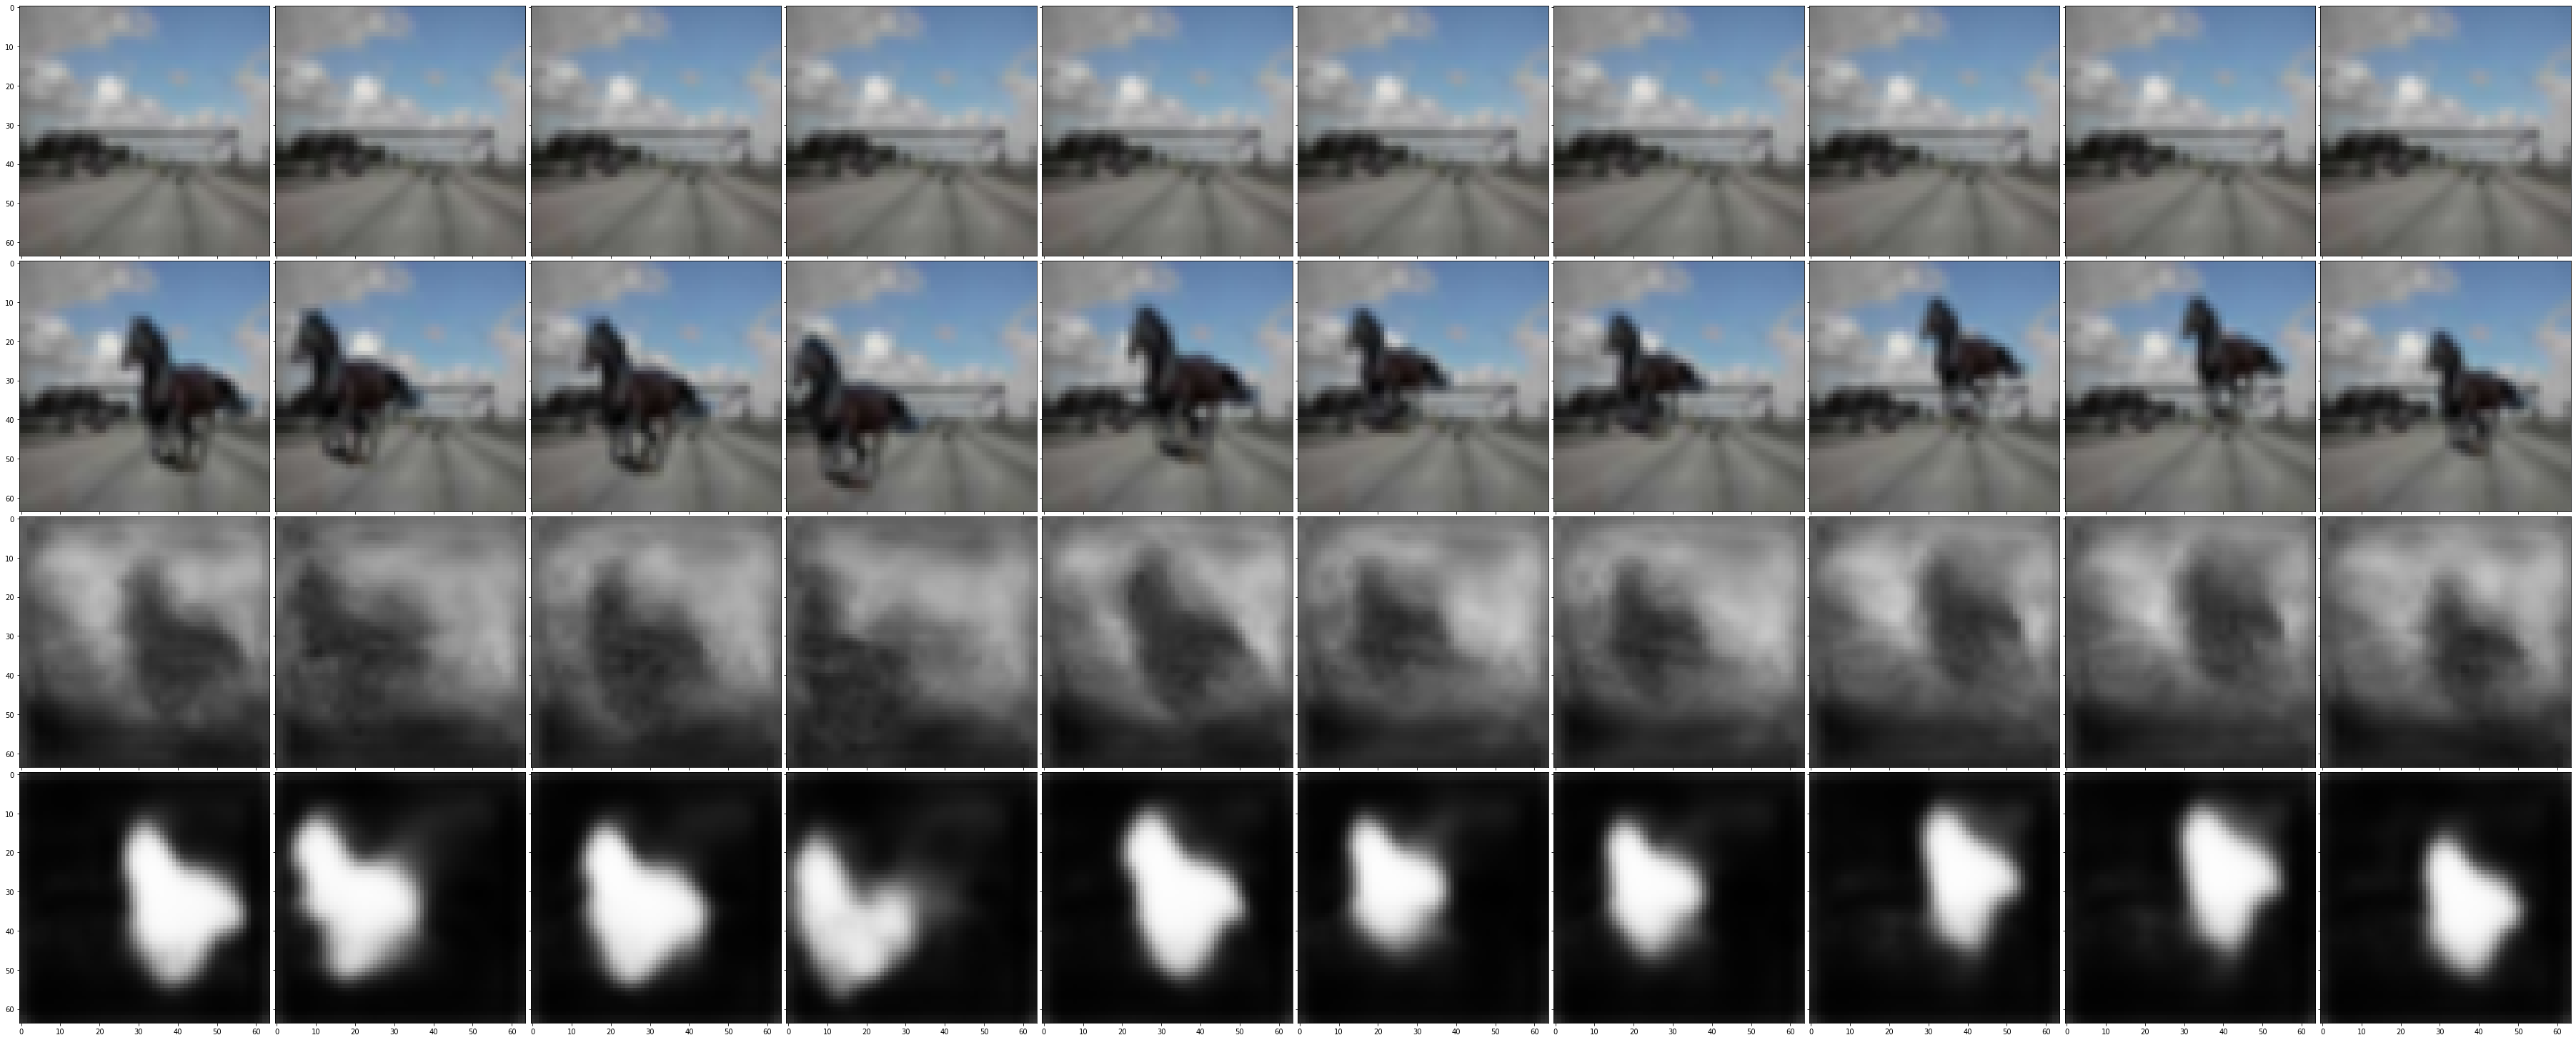

In [62]:
modal.eval()
test_loss = 0
correct = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
#import cv2_utils
from torchvision import transforms
"""
input_array = []
bg = "/content/gdrive/My Drive/eva-04/S15A/Dataset_224/bg/bg1.jpg"
overlay = "/content/gdrive/My Drive/eva-04/S15A/Dataset_224/bg1/fg_1/overlay/14.jpg"
depth = "/content/gdrive/My Drive/eva-04/S15A/Dataset_224/bg1/fg_1/depth/14.jpg"
mask = "/content/gdrive/My Drive/eva-04/S15A/Dataset_224/bg1/fg_1/mask/14.jpg"

bg_image = Image.open(bg).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
bg_image = bg_image.resize((64,64)) 
overlay_image = Image.open(overlay).convert('RGB') # even grey scale images will be converted to RGB with 3 channels
overlay_image = overlay_image.resize((64,64))
depth_image = Image.open(depth) # even grey scale images will be converted to RGB with 3 channels
depth_image = depth_image.resize((64,64))
mask_image = Image.open(mask)
mask_image = mask_image.resize((64,64))

tr = transforms.ToTensor()
bg_image = tr(bg_image)
overlay_image = tr(overlay_image)
mask_image = tr(mask_image)
depth_image = tr(depth_image)

input_array.append(bg_image)
input_array.append(overlay_image)
input_array.append(depth_image)
input_array.append(mask_image)
"""
count = 0
#w = torch.load("/content/unet_mse.pth")
#print(modal.layer_name.weight)
#modal.load_state_dict(w)
import time      
im_array = []
bg_array = []
fgbg_array = []
depth_array = []
mask_array =[] 
with torch.no_grad(): 
  #preds = np.zeros((1,1,2350,64), dtype=np.float32)
  #labels = np.zeros((1,1,2350,64),dtype=np.float32)
    
  for input_array1 in val_loader:
      count = count + 1
      #print(input_array1[0])
      bg = input_array1[0].to(device)
      fgbg = input_array1[1].to(device)
      depth_img = input_array1[2].to(device)
      mask_img = input_array1[3].to(device)

      #print('file=',input_array1[4])
      #load modal stats
      #for p in modal.parameters():
      #  print(p.data)  
      
      #print(modal.layer_name.weight)
      #fgbg = fgbg.add(bg)
      concat = torch.cat([bg,fgbg],dim=1)
      output = modal(concat)
      
      bg = bg.cpu()
      fgbg = fgbg.cpu()
      
      img = output[0].cpu()
      img = F.interpolate(img, size=(64, 64),mode='bilinear',align_corners=False)
      mask = output[1].cpu()
      mask = F.interpolate(mask, size=(64, 64),mode='bilinear',align_corners=False)
      depth_array.append(img)
      mask_array.append(mask)
      bg = F.interpolate(bg, size=(64, 64),mode='bilinear',align_corners=False)
      fgbg = F.interpolate(fgbg, size=(64, 64),mode='bilinear',align_corners=False)
      bg_array.append(bg)
      fgbg_array.append(fgbg)

      #pred = pred.cpu().numpy()
      label = depth_img.cpu()
      depth_img = depth_img.cpu() 
      
      
    
      # center crop to output size
      #label = label[7:label.shape[0]-7, 29:label.shape[1]-29]
      # store the label and the corresponding prediction
      #labels[:, :, idx] = label
      #preds[:, :, idx] = pred[0, 0, :, :]
      # load label
      #label = np.load(label_path)
      # calculating errors
      """
      rel_error = np.mean(np.abs(preds - labels)/labels)
      print('\nMean Absolute Relative Error: {:.6f}'.format(rel_error))

      rmse = np.sqrt(np.mean((preds - labels)**2))
      print('Root Mean Squared Error: {:.6f}'.format(rmse))

      log10 = np.mean(np.abs(np.log10(preds) - np.log10(labels)))
      print('Mean Log10 Error: {:.6f}'.format(log10))

      acc = np.maximum(preds/labels, labels/preds)
      delta1 = np.mean(acc < 1.25)
      print('Delta1: {:.6f}'.format(delta1))

      delta2 = np.mean(acc < 1.25**2)
      print('Delta2: {:.6f}'.format(delta2))

      delta3 = np.mean(acc < 1.25**3)
      print('Delta3: {:.6f}'.format(delta3))
      """
      #cv2_imshow(pred)
      #cv2_imshow(pred)
  
    #fgbg = fgbg.cpu()
      #print(out_numpy)
      #cv2_imshow(out_numpy)
      #img=img.resize((224,224))
      """
      if count == 10:
        trans = transforms.ToPILImage(mode=None)
        print(img.squeeze())
        print(label.squeeze())
        print("img:sum",torch.sum(img.squeeze()))
        print("pred:sum",torch.sum(label.squeeze()))
        #diff =   label.squeeze()-img.squeeze()
        #print("diff:",diff)
        #plt.imshow(trans(diff).convert('LA'))

        plt.imshow(trans(img.squeeze()).convert('LA'))
        #plt.imshow(trans(mask.squeeze()).convert('LA'))
        break
      """
      if count == 10:
        break
      #cv2.imwrite("/content/prediction/img1.jpg",img)
      
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

#im1 = np.arange(100).reshape((10, 10))
#im2 = im1.T
#im3 = np.flipud(im1)
#im4 = np.fliplr(im2)
trans = transforms.ToPILImage(mode=None)
        
for im in bg_array:
  im_array.append(trans(im.squeeze()))

for im in fgbg_array:
  im_array.append(trans(im.squeeze()))

for im in depth_array:
  im_array.append(trans(im.squeeze()).convert('LA'))

for im in mask_array:
  im_array.append(trans(im.squeeze()).convert('LA'))

fig = plt.figure(figsize=(64,64))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, im_array):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class DenseDepthDNN(torch.nn.Module):
    def __init__(self, dropout_value = 0.1):
        """"Constructor of the class"""
        super(DenseDepthDNN, self).__init__()
        # Input Block
        self.dropout_value = dropout_value
        #Depthwise separate 3 input channels into 3 output channels
        #it's first block uses following code:
        #x1 = Input
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        #x12 = GAP(x11)
        #x13 = FC(x12)
        #Uses ReLU and BN wherever applicable
        #Uses CIFAR10 as the dataset
        #Your target is 75% in less than 40 Epochs
        #self.conv1 = nn.Conv2d(3, 6, 5)  # RF= 
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        #torch.nn.Conv2d(in_channels, out_channels=k*in_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        #self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #x1 = Input 
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        
        #x1 = Input 3 channels
        #x2 = Conv(x1)
        self.x2 = nn.Sequential( #input 32*32*64, output=32*32*64, RF=4
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        #x3 = Conv(x1 + x2) , no x1
        self.x3 = nn.Sequential(  #input 32*32*64, output=32*32*64, RF=6
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        #x4 maxpool (x1+x2+x3) no x1
        self.x4 = nn.MaxPool2d(2, 2) #input 32*32*128, output=16*16*128, RF=7
        
        #x5 = Conv(x4)
        self.x5 = nn.Sequential( #input 16*16*128, output=16*16*128, RF=14
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )
        
        #x6 = Conv(x4 + x5)
        self.x6 = nn.Sequential( #input 16*16*256, output=16*16*128, RF=16
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )

        #x7 = Conv(x4 + x5 + x6)
        self.x7 = nn.Sequential( #input 16*16*64, output=16*16*64, RF=18
            nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            #nn.Dropout(dropout_value)
        )
        #x8 = MaxPooling(x5 + x6 + x7)
        self.x8 = nn.MaxPool2d(2, 2) #input 16*16*384, output_size = (8*8*384), RF=19
        
        #x9 = Conv(x8)
        self.x9 = nn.Sequential( #input 8*8*384, output_size = (8*8*128), RF=38
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )
        #x10 = Conv (x8 + x9)
        self.x10 = nn.Sequential( #input 8*8*128, output_size = (8*8*64), RF=40
            nn.Conv2d(in_channels=640, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )
        #x11 = Conv (x8 + x9 + x10)
        self.x11 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=896, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            #nn.Dropout(dropout_value)
        )
        
        """
        # OUTPUT BLOCK -> Add GAP Layer
        self.x12_gap = nn.Sequential( # input 8*8*64, output_size = (1*1*64), Receptive FieldF=42
            nn.AvgPool2d(kernel_size=8)
        )

        self.x13_fc = nn.Sequential(
            nn.Linear(in_features=64, out_features=10)
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        """
        
        #Remove gap layer and add additional conv layers
        self.x11_conv_256 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        self.x11_conv_512 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        self.x11_inconv_256 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        
        self.x11_inconv_128 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )
        
        self.x11_inconv_64 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x11_inconv_32 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x11_inconv_16 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(dropout_value)
        )

        self.x12_conv_1_1 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1)
            #nn.Dropout(dropout_value)
        )
        self.x13_final = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        )

        self.dropout = nn.Dropout(self.dropout_value)

    
    def forward(self, x1):
        #x1 = Input 
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        
        x2 = self.x2(x1) #                          
        #print('x2=',len(x2))
        #x1_x2 = torch.cat((x1, x2))
        #x1_x2 = torch.add((x1, x2))
        x3 = self.x3(x2)                            #RF2
        x1_x2_x3 = torch.cat((x2, x3),dim=1) 
        #x1_x2_x3 = x2.add(x3)                       #concatnation
        x4 = self.x4(x1_x2_x3)                      #RF3
        x5 = self.x5(x4)                            #RF6
        #print('x5=',len(x5))
        x4_x5 = torch.cat((x4, x5),dim=1)
        #x4_x5 = x4.add(x5)
        x6 = self.x6(x4_x5)  #RF8
        #interpolate
        x4=torch.nn.functional.interpolate(x4, size=(64,64))                         
        x5=torch.nn.functional.interpolate(x5, size=(64,64))                        
        x6=torch.nn.functional.interpolate(x6, size=(64,64))                        
        #print('x6=',len(x6))
        x5_x6 = torch.cat((x5, x6),dim=1)
        #x5_x6 = x5.add(x6)
        x4_x5_x6 = torch.cat((x4, x5_x6),dim=1)
        #x4_x5_x6 = x4.add(x5_x6)
        x7 = self.x7(x4_x5_x6) #RF10
        x5_x6_x7 = torch.cat((x5_x6, x7),dim=1)
        #x5_x6_x7 = x5_x6.add(x7)
        x8 = self.x8(x5_x6_x7) #RF11
        x9 = self.x9(x8) #RF22
        #interpolate 
        x8=torch.nn.functional.interpolate(x8, size=(64,64))                        
        x9=torch.nn.functional.interpolate(x9, size=(64,64))                        
        #print('x9=',len(x9))
        x8_x9 = torch.cat((x8, x9),dim=1)
        #x8_x9 = x8.add(x9)
        x10 = self.x10(x8_x9) #RF24
        
        #print('x10=',len(x10))
        x8_x9_x10 = torch.cat((x8_x9, x10),dim=1)
        #x8_x9_x10 = x8_x9.add(x10)
        x11 = self.x11(x8_x9_x10) #RF26
        #print('x11=',len(x11))
        #----->x12 = self.x12_gap(x11)
        #increase the channels
        x11_conv_256 = self.x11_conv_256(x11) #RF28
        x11_conv_512 = self.x11_conv_512(x11_conv_256) #RF30
        x11_inconv_256 = self.x11_inconv_256(x11_conv_512) #RF32
        x11_inconv_128 = self.x11_inconv_128(x11_inconv_256) #RF34
        x11_inconv_64 = self.x11_inconv_64(x11_inconv_128) #RF36
        x11_inconv_32 = self.x11_inconv_32(x11_inconv_64) #RF38
        x11_inconv_16 = self.x11_inconv_16(x11_inconv_32) #RF40

        #{{}}

        x12_conv_1_1 = self.x12_conv_1_1(x11_inconv_16)
        #print('x12=',len(x12))
        #----->x12 = x12.view(-1, 64)
        #---->x13 = self.x13_fc(x12)

        #print('x13=',len(x13))
        #x13 = x13.view(-1, 10)
        #print('x13=',len(x13))
        #---->x14 = x13.view(-1, 10)
        #-->return F.log_softmax(x13, dim=-1)
        x13_final = self.x13_final(x12_conv_1_1) #RF36
        return x13_final